# AGGREGATION OF AFFINE ESTIMATORS

N.B. : Just run the function till the "Test" section.
There, you will be able to create your own signal, and tune the following :
- number of data
- number of estimators
- family of estimators
- prior distribution
- temperature

In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline

# Signal & Data construction

In [198]:
def measured_signal(n, min_n, max_n, signal, means, variances, plot = False):
    X = np.random.uniform(min_n, max_n, n)
    idx = np.argsort(X)
    X = X[idx]
    
    cov_matrix = np.diag(variances)
    ksi = np.random.multivariate_normal(means, cov_matrix)
    
    Y = signal(X) + ksi
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(X, signal(X), color = 'b', label = 'Real signal')
        ax.plot(X, Y, color = 'r', label = 'Measured signal')
        legend = ax.legend(loc='upper left', shadow=True)
        plt.show()
        
    return X, Y

# Construction of the filters

In [68]:
def ordered_projection(y):
    n = len(y)
    lbd = np.random.randint(0,n)
    
    
    if n%2 == 0:
        m = int(n/2)
        a = [1 if i <=lbd else 0 for i in range(m+1)]
        a = np.hstack([a, a[1:-1][::-1]])
    else:
        m = int((n-1)/2)
        a = [1 if i <=lbd else 0 for i in range(m+1)]
        a = np.hstack([a, a[1:][::-1]])
    
    estimator = a*y
    estimator = np.fft.ifft(estimator)
    A = np.fft.ifft(np.diag(a))
    return estimator, A

In [69]:
def tikhonov_philipps_filter(y):
    n = len(y)
    w = np.random.uniform(0,n)
    alpha = np.random.uniform(0.1,10)
    
    if n%2 == 0:
        m = int(n/2)
        a = [1./(1+(float(i)/w)**alpha) for i in range(m+1)]
        a = np.hstack([a, a[1:-1][::-1]])
    else:
        m = int((n-1)/2)
        a = [1./(1+(float(i)/w)**alpha) for i in range(m+1)]
        a = np.hstack([a, a[1:][::-1]])
        
    estimator = a*y
    estimator = np.fft.ifft(estimator)
    A = np.fft.ifft(np.diag(a))
    return estimator, A

In [70]:
def pinsker_filter(y):
    n = len(y)
    w = np.random.uniform(0,n)
    alpha = np.random.uniform(0.1,10)
    
    if n%2 == 0:
        m = int(n/2)
        a = [np.max([0, (1-float(i**alpha)/w)]) for i in range(m+1)]
        a = np.hstack([a, a[1:-1][::-1]])
    else:
        m = int((n-1)/2)
        a = [np.max([0, (1-float(i**alpha)/w)]) for i in range(m+1)]
        a = np.hstack([a, a[1:][::-1]])
        
    estimator = a*y
    estimator = np.fft.ifft(estimator)
    A = np.fft.ifft(np.diag(a))
    return estimator, A

In [112]:
def kernel_ridge_regression(y, X):
    n = len(y)
    lbd = np.random.randint(0,n)
    gamma = 1.
    K = np.array([ [ np.exp(-gamma*np.abs(i-j)) for j in X] for i in X])
    A = K.dot(np.linalg.inv(K + n*lbd*np.diag(np.ones(n))))
    
    estimator = A.dot(y.T)
    estimator = np.fft.ifft(estimator)
    
    return estimator, A

# Functions to construct the estimator & to aggregate them with EWA

In [176]:
def estimator_construction(Y, M, sigmas_square, X, family = 'pinsker filter'):
    ### Initialisation ###
    y = np.fft.fft(Y) # Décomposition de l'input en série de Fourier
    n = len(y)

    constante = np.sum(sigmas_square)/len(sigmas_square)
    cov_matrix = np.diag(sigmas_square)

    estimators = []
    risks = []
    
    for i in range(M): 
        if family == 'pinsker filter':
            estimator, A = pinsker_filter(y)
        elif family == 'ordered projection':
            estimator, A = ordered_projection(y)
        elif family == 'tikhonov philipps filter':
            estimator, A = tikhonov_philipps_filter(y)
        elif family == 'kernel ridge regression':
            estimator, A = kernel_ridge_regression(y, X)
        else:
            raise Exception('family should belong to "pinsker filter", "ordered projection", "tikhonoc philipps filter" or " kernel ridge regression"')
            
        risk = np.linalg.norm(Y-estimator)**2/len(Y) + 2./n*np.trace(cov_matrix.dot(A)) - constante
        estimators.append(estimator)
        risks.append(risk)
        
    return estimators, risks

In [177]:
def aggregation(Y, estimators, risks, prior_distribution, temperature ):
    
    ### Posterior distribution
    norm = np.sum([np.exp(-float(n)*r/temperature)*prior_distribution[i] for i, r in enumerate(risks)])
    theta = [np.exp(-float(n)*r/temperature)/norm for r in risks]
    posterior_distrib = [theta[i]*prior for i, prior in enumerate(prior_distribution)]
    
    ### Aggregation ###
    f_EWA = np.sum([estimators[i]*posterior for i, posterior in enumerate(posterior_distrib)], axis = 0)
    
    return f_EWA

# Tests

In [199]:
def signal(x):
    Y = x*np.sin(np.exp(x))
    return Y

def signal2(x):
    Y = [i if i< 0.5 else i-1 for i in x]
    return Y

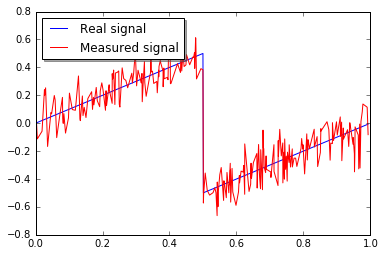

In [200]:
n = 256

### NOISE ###
variances = [0.01 for i in range(n)]
means = [0. for i in range(n)]

X, Y = measured_signal(n, 0, 1, signal2, means, variances, plot = True)

In [206]:
### INITIALISATION ###
# 'family' should belong to : 'pinsker filter', 'tikhonov philipps filter', 
#                             'ordered projection' or 'kernel ridge regression'
number_of_estimators = 3000
family = 'pinsker filter'
estimators, risks = estimator_construction(Y, number_of_estimators, sigmas_square, X, family = family)

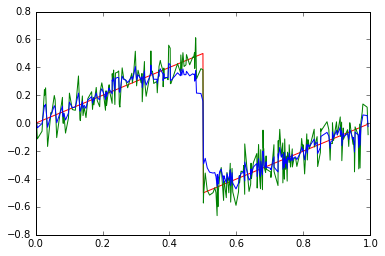

In [225]:
### AGGREGATION ###
prior_distribution = 1./number_of_estimators*np.ones(number_of_estimators)
temperature = 3
f_EWA = aggregation(Y, estimators, risks, prior_distribution, temperature)


plt.plot(X, signal2(X), color = 'r')
plt.plot(X, Y, color = 'g')
plt.plot(X, f_EWA, color = 'b')
plt.show()

In [226]:
print 'Collected signal : ', np.linalg.norm(Y - signal2(X))**2/n
print 'Reconstr. signal : ', np.linalg.norm(f_EWA - signal2(X))**2/n

Collected signal :  0.0105986052951
Reconstr. signal :  0.00491790790162
